### Visualizing the label evolution behavior for specific outputs (for the CIFAR and TMED datasets)

In [1]:
import os
import numpy as np
import pandas as pd
import glob
import re
from scipy.special import softmax

from scipy.io import loadmat
from skimage.transform import resize
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, accuracy_score

import PIL.Image as Image
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

from platt_scaling import platt_scaling_fit
from conformal_pred_algos import *
from conformal_pred_metrics import *

In [2]:
dataset = 'TMED'
if dataset == 'CIFAR':
    folder_A = '../logs/R18_cifar_smaller_val/round0/csvs/'
    folder_B = '../logs/R18_cifar_smaller_val/round1/csvs/'
elif dataset == 'TMED':
    folder_A = '../logs/tmed_highlr/round0/csvs/'
    folder_B = '../logs/tmed_highlr/round1/csvs/'

def extract_file_index(filename):
    # Use regular expression to find numerical part in the filename
    match = re.findall(r'\d+', filename)[-3]
    if match:
        numerical_part = int(match)
        return numerical_part
    else:
        # Return a default value or handle the case where no numerical part is found
        return None

# sort ascending by the numerical suffix for each file with regex search
def sort_by_epoch(files_list):
    indices = []
    for i in range(len(files_list)):
        index = extract_file_index(files_list[i])
        indices.append(index)
    new_array = [None] * len(indices)
    for j in range(len(indices)):
        new_array[indices[j]] = files_list[j]
    return new_array

train_csvs_A = sort_by_epoch(glob.glob(f"{folder_A}/train_*.csv"))
train_csvs_B = sort_by_epoch(glob.glob(f"{folder_B}/train_*.csv"))
test_csvs_A = glob.glob(f"{folder_A}/test_*.csv")
test_csvs_B = glob.glob(f"{folder_B}/test_*.csv")


In [3]:
def get_dfs(csv_paths):
    dfs = [pd.read_csv(x) for x in csv_paths]
    dfs = [df.sort_values(by=['filename']).reset_index() for df in dfs]
    return dfs

t_df_A, t_df_B, te_df_A, te_df_B = [get_dfs(paths) for paths in [train_csvs_A, train_csvs_B, test_csvs_A, test_csvs_B]]
output_cols = [x for x in t_df_A[0].columns if 'outputs' in x]

In [4]:
t_df_A[0]

,index,Unnamed: 0,filename,y,outputs_0,outputs_1,outputs_2
0,951,951,/data/TMED/approved_users_only/view_and_diagno...,1,-0.390232,0.395367,-0.207590
1,1578,1578,/data/TMED/approved_users_only/view_and_diagno...,1,-0.084951,1.143031,-0.596196
2,33,33,/data/TMED/approved_users_only/view_and_diagno...,1,0.147179,0.555808,-0.128697
3,988,988,/data/TMED/approved_users_only/view_and_diagno...,1,-0.707449,0.084105,0.954029
4,904,904,/data/TMED/approved_users_only/view_and_diagno...,1,-0.666001,-0.053550,1.528383
...,...,...,...,...,...,...,...
10061,3422,3422,/data/TMED/approved_users_only/view_and_diagno...,1,-0.363223,0.131442,0.080356
10062,4397,4397,/data/TMED/approved_users_only/view_and_diagno...,1,-0.564044,0.048592,0.352578
10063,2079,2079,/data/TMED/approved_users_only/view_and_diagno...,1,-0.531445,0.190901,0.153893
10064,1247,1247,/data/TMED/approved_users_only/view_and_diagno...,1,-0.479090,0.570673,-0.101790


In [5]:
def df_to_logits(df):
    # take the outputs_x rows and conver them to array of (N, C)
    cols = [x for x in df.columns if 'outputs' in x]
    logits = df[cols].to_numpy()
    preds = softmax(logits, axis=1)
    return logits

t_pred_A = [df_to_logits(d) for d in t_df_A]
t_pred_B = [df_to_logits(d) for d in t_df_B]
te_pred_A = [df_to_logits(d) for d in te_df_A]
te_pred_B = [df_to_logits(d) for d in te_df_B]
print(t_pred_A[0].shape)
print(te_pred_A[0].shape)

(10066, 3)
(3602, 3)


In [6]:
from torchvision.datasets import CIFAR10
from datamodule_cifar import CIFAR10_Quadrants
cfgs = {"root":"/data/", "download":False}
cifar_10_tr = CIFAR10(train=True, **cfgs)
cifar_Q_tr = CIFAR10_Quadrants(split='train', **cfgs)
cifar_10_te = CIFAR10(train=False, **cfgs)
cifar_Q_te = CIFAR10_Quadrants(split='train', **cfgs)

def LoadImage(file_path):
    im = Image.open(file_path)
    im = np.asarray(im)/255
    return im

def ShowGrayscaleImage(file_path, title='', ax=None):
    
    im = LoadImage(file_path)
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im , cmap=plt.cm.gray, vmin=0, vmax=1) #im is of float, 0-1
    plt.title(title)

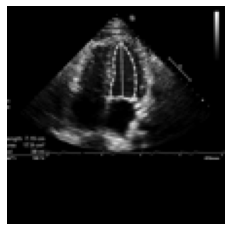

In [7]:
def get_TMED_image_by_id(uid):
    ShowGrayscaleImage(uid)

def get_CIFAR_image_by_id(uid, training_set=True):
    image_id = uid // 4
    if training_set:
        img_full, _ = cifar_10_tr[image_id]
        img_quad = cifar_Q_tr[uid]['x']
    else:
        img_full, _ = cifar_10_te[image_id]
        img_quad = cifar_Q_te[uid]['x']
    return img_full, img_quad

if dataset == 'CIFAR':
    img_full, img_quad = get_CIFAR_image_by_id(2)
    img_full.resize((224,224)).show()
    img_quad.resize((224,224)).show()
else:
    get_TMED_image_by_id(t_df_A[0].iloc[0]['filename'])

2


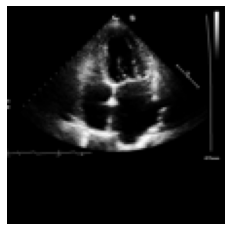

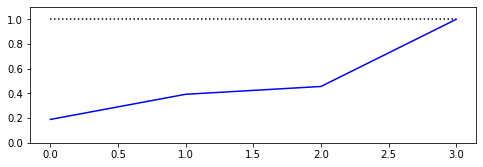

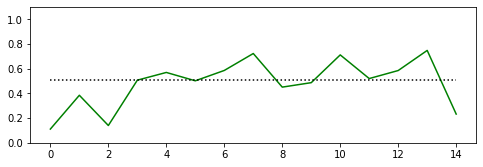

2


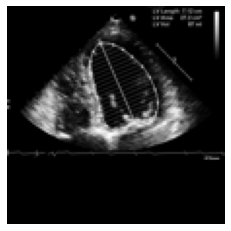

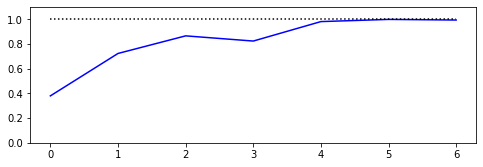

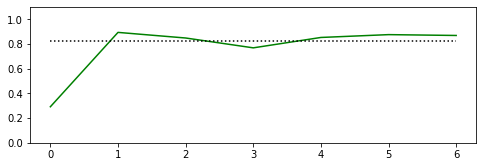

2


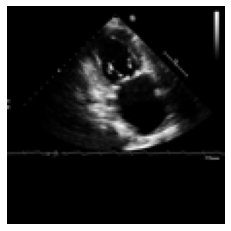

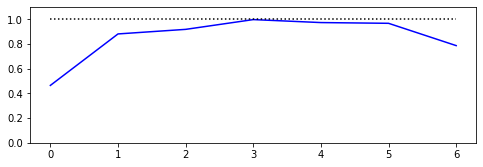

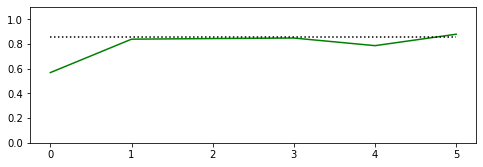

2


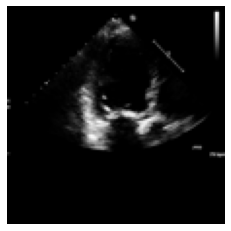

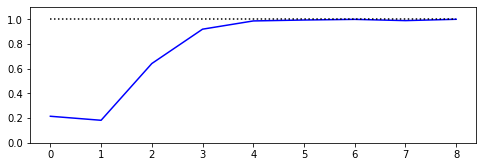

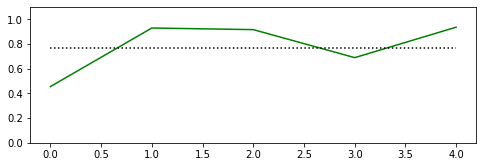

2


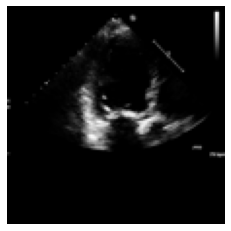

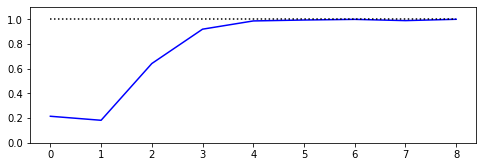

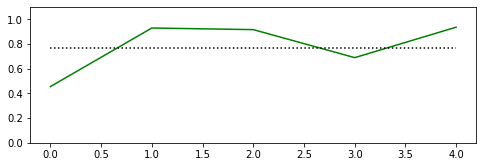

2


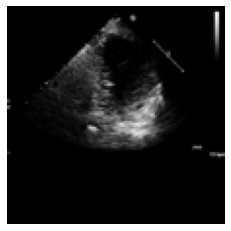

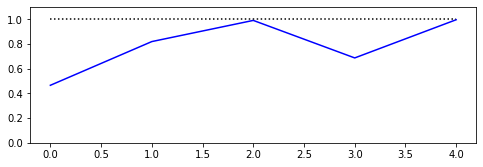

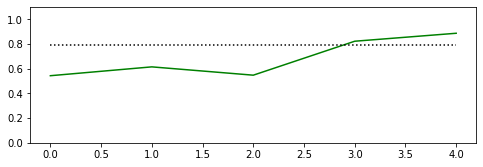

2


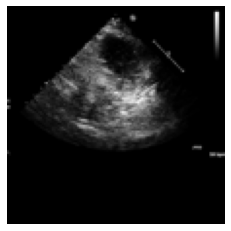

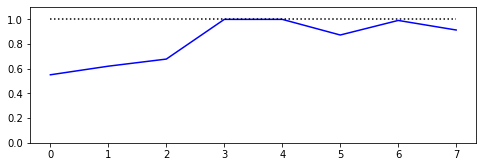

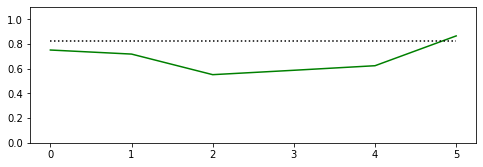

2


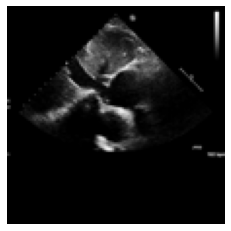

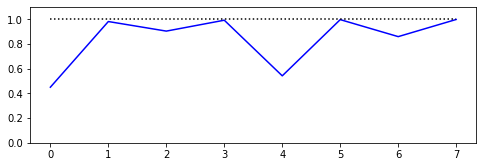

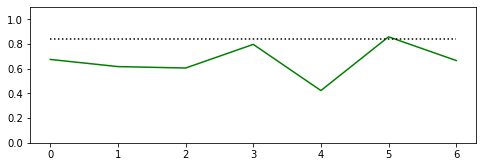

2


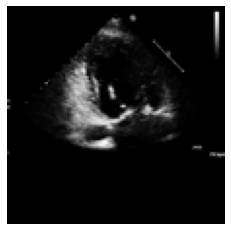

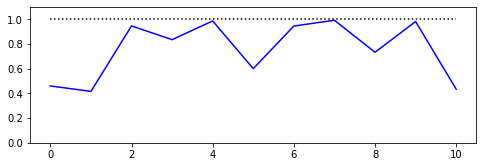

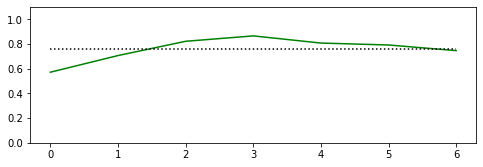

2


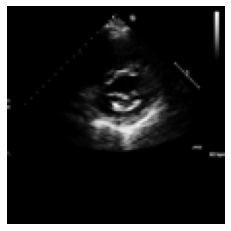

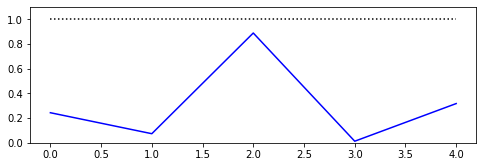

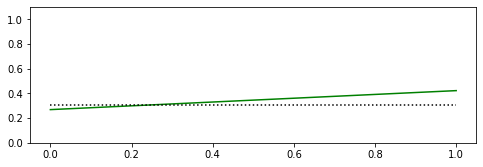

2


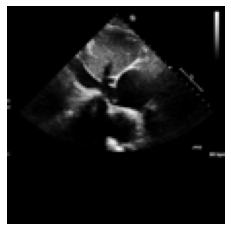

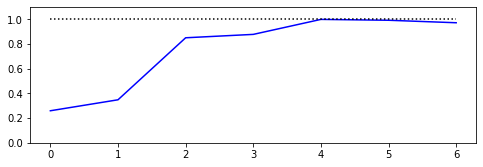

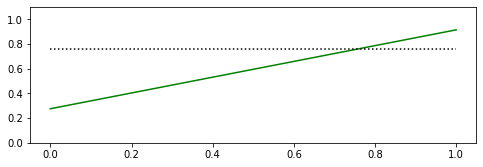

2


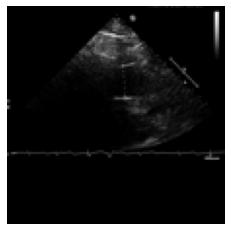

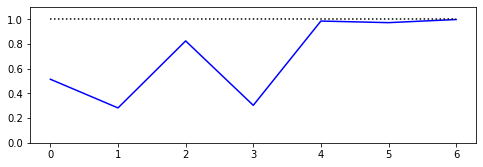

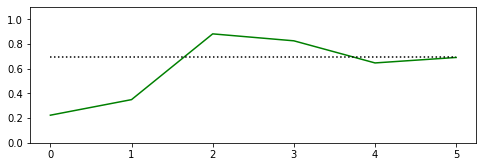

2


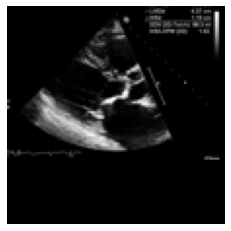

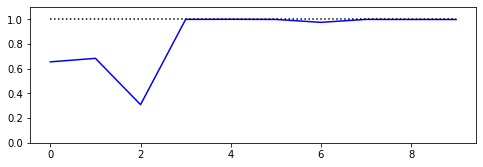

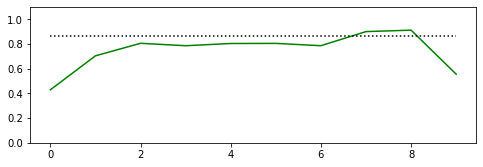

2


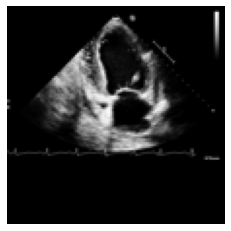

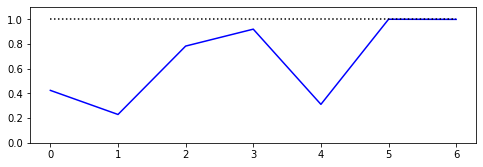

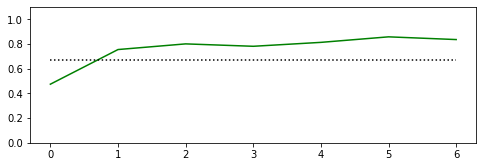

2


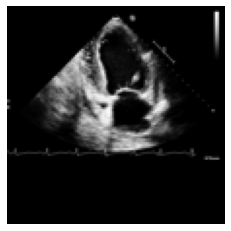

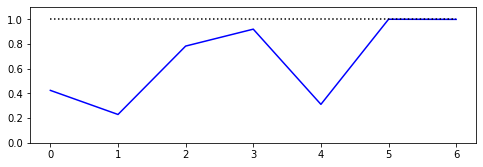

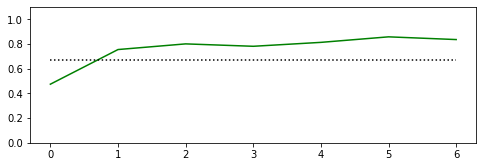

In [8]:
# plot the progression of training confidence
def plot_confidence_progression(series, marker_fmt='b-', target=1.0):
    plt.figure(figsize=(8, 2.5))
    plt.plot(series, marker_fmt)
    plt.plot(range(len(series)), np.full(shape=len(series), fill_value=target), color='black', linestyle=':')
    ax = plt.gca()
    ax.set_ylim([0, 1.1])
    plt.show()

def plot_pred_progression(uid):
    if dataset == 'CIFAR':
        img_full, img_quad = get_CIFAR_image_by_id(uid)
        img_full.resize((112,112)).show()
        img_quad.resize((112,112)).show()
    else:
        get_TMED_image_by_id(uid)
    gt = t_df_A[0][t_df_A[0]['filename']==uid]['y'].to_numpy()[0]
    print(gt)
    preds_A, preds_B = [], []
    
    for epoch in range(len(t_pred_A)):
        df_epoch = t_df_A[epoch]
        df_uid = df_epoch[df_epoch['filename']==uid]
        if len(df_uid) > 0:
            preds_epoch = softmax(df_uid[output_cols].to_numpy(), axis=1)
            preds_A.extend(preds_epoch)
        
    for epoch in range(len(t_pred_B)):
        df_epoch = t_df_B[epoch]
        df_uid = df_epoch[df_epoch['filename']==uid]
        if len(df_uid) > 0:
            preds_epoch = softmax(df_uid[output_cols].to_numpy(), axis=1)
            preds_B.extend(preds_epoch)
        
    preds_A, preds_B = np.array(preds_A).squeeze(), np.array(preds_B).squeeze()
    conf_A, conf_B = preds_A[:, gt], preds_B[:, gt]
    
    
    plot_confidence_progression(conf_A, 'b-', target=1.0)
    plot_confidence_progression(conf_B, 'g-', target=np.mean(conf_A))
    
#query = 20
#[plot_pred_progression(i) for i in np.arange(4)+query]
q = 70
for i in range(15):
    query = t_df_A[0][t_df_A[0]['y'] == 2].iloc[q + i]['filename']
    plot_pred_progression(query)